# ACE files and XS

F4Enix leverages the [endf](https://github.com/paulromano/endf-python) python package to parse ACE files. Building on this, F4Enix allow to compute xs for materials (i.e. any collection of zaids) and to collapse xs into pre-defined energy groups. 

## Retrieve a continous or collapsed XS

### Single nuclides

A number of pre-defined energy groups are available and can be explored with the following code. All energies are expressed in [eV].

In [1]:
from f4enix.egroups import GROUP_STRUCTURES

print(f'Avaialble groups: {GROUP_STRUCTURES.keys()}')
print('\nCASMO-8 energies in eV:')
print(GROUP_STRUCTURES['CASMO-8'])

Avaialble groups: dict_keys(['CASMO-2', 'CASMO-4', 'CASMO-8', 'CASMO-16', 'CASMO-25', 'CASMO-40', 'VITAMIN-J-42', 'SCALE-44', 'MPACT-51', 'MPACT-60', 'MPACT-69', 'CASMO-70', 'XMAS-172', 'VITAMIN-J-175', 'SCALE-252', 'TRIPOLI-315', 'SHEM-361', 'CCFE-709', 'UKAEA-1102', 'ECCO-1968'])

CASMO-8 energies in eV:
[0.00e+00 5.80e-02 1.40e-01 2.80e-01 6.25e-01 4.00e+00 5.53e+03 8.21e+05
 2.00e+07]


The following is an example where both continous and collapsed cross sections for C-12 are requested. More than one xs can be requested at the same tieme. Note that the path to ace files can be either given with a dictionary as demonstrated here or giving the path to an MCNP xsdir file.

Text(0.5, 1.0, 'C-12')

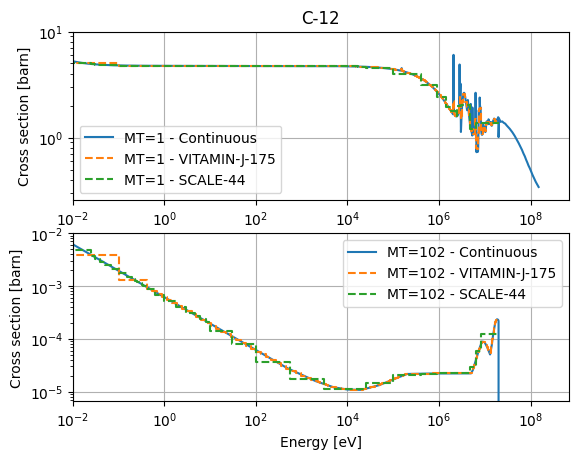

In [2]:
import matplotlib.pyplot as plt

from f4enix.input.ace import get_xs

# use a dictionary for custom paths to the ace files
local_ace = {
    ("1001", "FENDL32"): {"path": "ace/01H_001"},
    ("1002", "FENDL32"): {"path": "ace/01H_002"},
    ("6012", "FENDL32"): {"path": "ace/06C_012"},
    }

# Get the continous xs
xs_continuous, ys_continuous =  get_xs(
    this='6012',
    types=[1, 102],
    library="FENDL32",
    ace_filepaths=local_ace,
)

# Plot the continuous xs
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(xs_continuous, ys_continuous[0], label="MT=1 - Continuous")
ax2.plot(xs_continuous, ys_continuous[1], label="MT=102 - Continuous")

# Get the collapsed xs in two differen groups
for group in ["VITAMIN-J-175", "SCALE-44"]:
    xs_collapsed, ys_collapsed =  get_xs(
        this='6012',
        types=[1, 102],
        library="FENDL32",
        ace_filepaths=local_ace,
        group_structure=group,
    )
    # plot the collapsed xs
    ax1.step(xs_collapsed, ys_collapsed[0], label=f"MT=1 - {group}", linestyle="--")
    ax2.step(xs_collapsed, ys_collapsed[1], label=f"MT=102 - {group}", linestyle="--")

# make the plot more informative
for ax in (ax1, ax2):
    ax.set_xlabel("Energy [eV]")
    ax.set_ylabel("Cross section [barn]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.grid()
    ax.set_xlim(1e-2)
ax1.set_ylim(top=10)
ax2.set_ylim(top=1e-2)
ax1.set_title("C-12")



The average xs value in an energy bin is obtained as the integral of the xs value in the bin divided by the bin width. The integral is performed numerically, hence, the number of integration point may influence the result. This is especially true:
- if the energy bins are wide
- if many resonances are present in the energy bin.

By default F4Enix uses 100 points in each energy bin, which should be sufficient to reach convergence for most applications. This parameter can be changed though and it is the responsability of the user to verify it suitability for its specific application.

Let's see an example of this effect in the resonance region of C-12 total cross section:

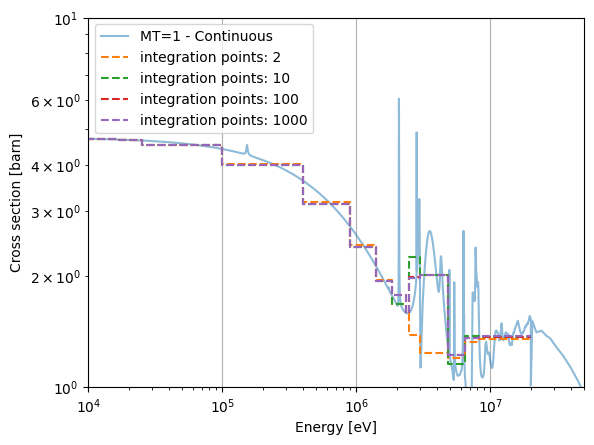

In [3]:
# Plot the continuous xs
fig, ax = plt.subplots()
ax.plot(xs_continuous, ys_continuous[0], label="MT=1 - Continuous", alpha=0.5)

# Get the collapsed xs with different number of integration points
for integral_points in [2, 10, 100, 1000]:
    xs_collapsed, ys_collapsed =  get_xs(
        this='6012',
        types=['total'],
        library="FENDL32",
        ace_filepaths=local_ace,
        group_structure="SCALE-44",
        integral_points=integral_points,
    )
    ax.step(xs_collapsed, ys_collapsed[0],
            label=f"integration points: {integral_points}", linestyle="--")

# plot parameters
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [barn]")
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [barn]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e4, 5e7)
ax.set_ylim(1, 1e1)
ax.legend()
ax.grid()

### Material or elements

It is also possible to compute (and collapse) the xs of a material or of an element.

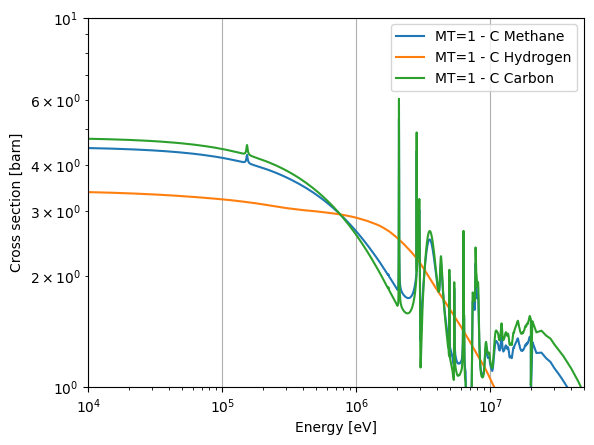

In [10]:
from f4enix.input.libmanager import LibManager
from f4enix.input.materials import Material

lm = LibManager(xsdir_path='ace/xsdir_test', defaultlib='32c')

# Create a material object (Methane - CH4)
mat = Material.from_zaids([(6012, 1), (1000, 4)], lm, '32c', name='Methane')
# elements can be simply obtained as material with only one element
elem = Material.from_zaids([(1000, 1)], lm, '32c', name='Hydrogen')
# a material of only one zaid is also equivalent
elem2 = Material.from_zaids([(6012, 1)], lm, '32c', name='Carbon')

fig, ax = plt.subplots()
# Get the total cross section
for this in [mat, elem, elem2]:
    xs_continuous, ys_continuous =  get_xs(
        this=this,
        types=['total'],  # main xs can also be requested by strings
        # let's use an xsdir this time instead of the dictionary
        library="32c",  # need to use the same suffix as per xsdir
        ace_filepaths='ace/xsdir_test',
    )

    # Plot the continuous xs
    ax.plot(xs_continuous, ys_continuous[0], label=f"MT=1 - {this.header}")

# plot parameters
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [barn]")
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Cross section [barn]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e4, 5e7)
ax.set_ylim(1, 1e1)
ax.legend()
ax.grid()